In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math,copy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_df=pd.read_csv("/content/drive/MyDrive/CyberLabs_ML/binary_classification_train.csv", header=0)

x_tr=train_df.iloc[0:28800,1:21]
y_tr=train_df.iloc[0:28800,21]

x_cv=train_df.iloc[28800:38400,1:21]
y_cv=train_df.iloc[28800:38400,21]

x_tst=train_df.iloc[38400:48001,1:21]
y_tst=train_df.iloc[38400:48001,21]

x_tr1=x_tr.values
y_tr1=y_tr.values

x_cv1=x_cv.values
y_cv1=y_cv.values

x_tst1=x_tst.values
y_tst1=y_tst.values

print(x_tr1.shape)
print(y_tr1.shape)

(28800, 20)
(28800,)


In [4]:
def plot_data(X, y, ax, pos_label="y=1", neg_label="y=0", s=80, loc='best' ):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
    neg = neg.reshape(-1,)

    # Plot examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=s, c = 'red', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=s, label=neg_label, facecolors='none', edgecolors='blue', lw=3)
    ax.legend(loc=loc)

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False


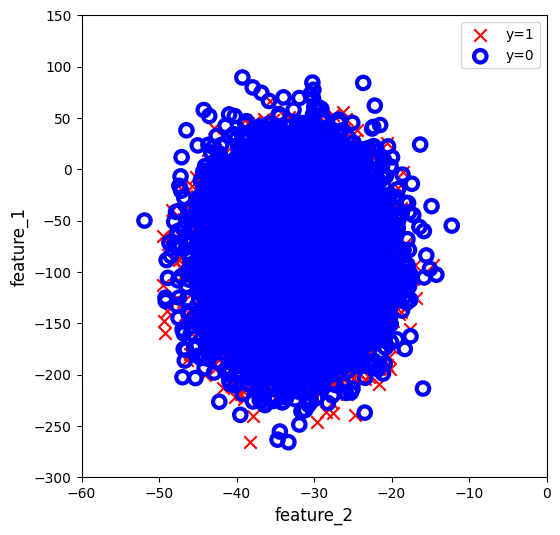

In [5]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plot_data(x_tr1[:,0:2], y_tr1, ax)


# Set limit of both axes
ax.axis([-60, 0, -300, 150])
ax.set_ylabel('feature_1', fontsize=12)
ax.set_xlabel('feature_2', fontsize=12)
plt.show()

Here, we have drawn scatter plot of 'Feature_1' vs 'Feature_2' of the given data . Similarly, scatter plots based on other pairs of features can also be drawn.  

In [6]:
def zscore_normalize_features(X):
    """
    computes  X, zcore normalized by column

    Args:
      X (ndarray (m,n))     : input data, m examples, n features

    Returns:
      X_norm (ndarray (m,n)): input normalized by column
      mu (ndarray (n,))     : mean of each feature
      sigma (ndarray (n,))  : standard deviation of each feature
    """
    # find the mean of each column/feature
    mu     = np.mean(X, axis=0)                 # mu will have shape (n,)
    # find the standard deviation of each column/feature
    sigma  = np.std(X, axis=0)                  # sigma will have shape (n,)
    # element-wise, subtract mu for that column from each example, divide by std for that column
    X_norm = (X - mu) / sigma

    return (X_norm, mu, sigma)

x_tr1_n, x_mu1, x_sig1 = zscore_normalize_features(x_tr1)
x_cv_n, x_mu2, x_sig2 = zscore_normalize_features(x_cv1)
x_tst_n, x_mu3, x_sig3 = zscore_normalize_features(x_tst1)

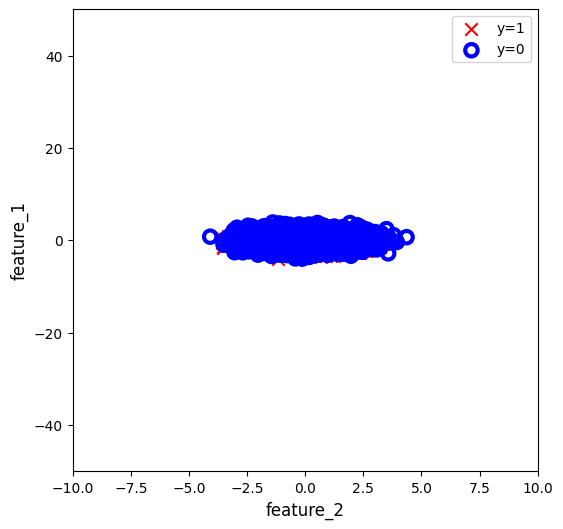

In [7]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
plot_data(x_tr1_n[:,0:2], y_tr1, ax)


# Set limit of both axes
ax.axis([-10, 10, -50, 50])
ax.set_ylabel('feature_1', fontsize=12)
ax.set_xlabel('feature_2', fontsize=12)
plt.show()

In [8]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Parameters
    ----------
    z : array_like
        A scalar or numpy array of any size.

    Returns
    -------
     g : array_like
         sigmoid(z)
    """
    g = 1.0/(1.0+np.exp(-z))

    return g


In [9]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters
      b (scalar)       : model parameter

    Returns:
      cost (scalar): cost
    """

    m = X.shape[0]
    cost = 0.0
    for i in range(m):
        z_i = np.dot(X[i],w) + b
        f_wb_i = sigmoid(z_i)
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)

    cost = cost / m
    return cost

In [10]:
def compute_gradient_logistic(X, y, w, b):
    """
    Computes the gradient for logistic regression

    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w.
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b.
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar

    return dj_db, dj_dw

In [11]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    """
    Performs batch gradient descent

    Args:
      X ((ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent

    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in

    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw
        b = b - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]} , w: {w}, b: {b} ")

    return w, b, J_history         #return final w,b and J history for graphing

In [24]:

w_tmp=np.array([ 0.01072573, -0.02271025,  0.01305204, -0.41207983,  0.00444579,  2.01671036,
  0.02927563,  0.01838219,  0.30439832,  0.03106443, -0.04400252, -0.01823015,
 -0.02090881,  0.71305104,  0.6750033,  -0.90375436,  0.10739341, -0.38271881,
 -0.36239627, -0.01814809]) #Value obtained after some previous iterations has been taken as initial values
b_tmp  = -1.3546959260131688
alph = 0.5
iters = 100

w_out, b_out, J_hist = gradient_descent(x_tr1_n, y_tr1, w_tmp, b_tmp, alph, iters)
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")


Iteration    0: Cost 0.24723760559362337 , w: [ 0.0105137  -0.0227631   0.01310797 -0.41283293  0.00412461  2.01720182
  0.02822212  0.01765744  0.30379362  0.03076587 -0.04386683 -0.01801219
 -0.02083913  0.71270236  0.67574538 -0.9036996   0.10727027 -0.38225966
 -0.36247255 -0.01760183], b: -1.353754812082491 
Iteration   10: Cost 0.24717295256991748 , w: [ 8.72131839e-03 -2.31554939e-02  1.36097546e-02 -4.18387774e-01
  1.43813250e-03  2.02130002e+00  1.95052711e-02  1.16725987e-02
  2.99578380e-01  2.82557188e-02 -4.27299365e-02 -1.61934531e-02
 -2.02285292e-02  7.10081016e-01  6.80564120e-01 -9.03728806e-01
  1.07097569e-01 -3.78004288e-01 -3.63692379e-01 -1.31035157e-02], b: -1.3463383944590246 
Iteration   20: Cost 0.2471436638974875 , w: [ 7.41461205e-03 -2.33832471e-02  1.40094097e-02 -4.21727060e-01
 -4.80066633e-04  2.02421251e+00  1.33959330e-02  7.49167559e-03
  2.97459724e-01  2.64459556e-02 -4.19148482e-02 -1.48991398e-02
 -1.97679102e-02  7.08364219e-01  6.82555264e-01

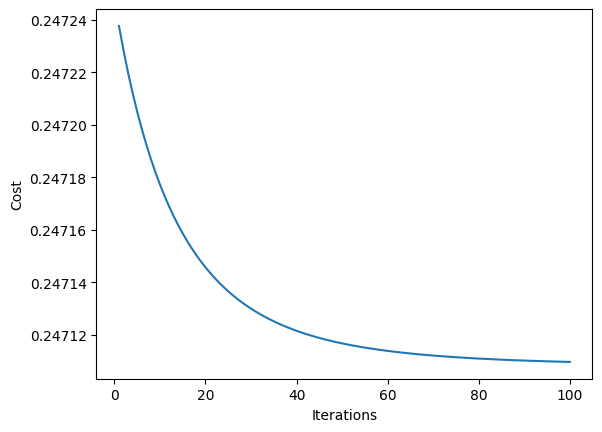

In [26]:
J_arr=np.array(J_hist)
iterations=np.arange(1,J_arr.shape[0]+1)

plt.plot(iterations,J_arr)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.show()


In [13]:

def predict(X, w, b):
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      w : (ndarray Shape (n,))  values of parameters of the model
      b : (scalar)              value of bias parameter of the model

    Returns:
      p : (ndarray (m,)) The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape
    p = np.zeros(m)


    # Loop over each example
    for i in range(m):
        z_wb = sigmoid(np.dot(X[i],w)+b)
        if z_wb>=0.5:
            p[i]=1
        else:
            p[i]=0

    return p





In [27]:
y_pred1 = predict(x_tr1_n, w_out,b_out)
print('Train Accuracy: %f'%(np.mean(y_pred1 == y_tr1) * 100))



Train Accuracy: 93.385417


In [30]:
y_pred2 = predict(x_cv_n, w_out,b_out)
print('Cross_Validation Accuracy: %f'%(np.mean(y_pred2 == y_cv1) * 100))

Cross_Validation Accuracy: 93.760417


In [18]:
#F1 Score Calc
def f_1_score(x,y):
  '''
  Calculate the F1 Score of the model
  '''
  a=0
  b=0
  for i in range(len(x)):
    if x[i]==1 and x[i]==y[i]:
      a+=1
    elif x[i]==1 and x[i]!=y[i]:
      b+=1
    else:
      pass
  pr=a/sum(x)
  re=a/sum(y)
  f_1=2*pr*re/(pr+re)
  return f_1

In [31]:
print("F1 Score on Train dataset: ",f_1_score(y_pred1,y_tr1))
print("F1 Score on CV dataset: ",f_1_score(y_pred2,y_cv1))
print("F1 Score on Test dataset: ",f_1_score(predict(x_tst_n,w_out,b_out),y_tst1))

F1 Score on Train dataset:  0.8932354424704366
F1 Score on CV dataset:  0.8972026771923804
F1 Score on Test dataset:  0.8932206313610488


In [32]:
test_df=pd.read_csv("/content/drive/MyDrive/CyberLabs_ML/binary_classification_test.csv", header=0)

x_arr_test=test_df.iloc[:,1:21].values
print(x_arr_test.shape)

x_test_norm, x_test_mu, x_test_sig = zscore_normalize_features(x_arr_test)


(12000, 20)


In [34]:
p = predict(x_test_norm,w_out,b_out)
print(p.shape)
print(type(p))
print(p[0:25])


(12000,)
<class 'numpy.ndarray'>
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
 0.]


In [35]:
log_reg_bin_df=pd.DataFrame(p)
log_reg_bin_df.to_csv('log_reg_bin.csv',index= False)

In [36]:
! ls

drive  log_reg_bin.csv	sample_data


In [37]:
! cat log_reg_bin.csv

0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
1.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
1.0
1.0
1.